Firstly we import all the functions we have written and load the data. We also set the models list to be used.

In [1]:
import os
from pathlib import Path
os.chdir(Path(globals()['_dh'][0]).parent)

from src.functions import *
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import joblib
# from pprint import pprint
from json import dumps as jdumps # For nice printing of dicts

dev = pd.read_csv("data/development_final_data.csv", index_col=0)
val = pd.read_csv("data/evaluation_final_data.csv", index_col=0)
devHP = pd.read_csv("data/development_final_data_HP.csv", index_col=0)
valHP = pd.read_csv("data/evaluation_final_data_HP.csv", index_col=0)

modelsList = ['ElasticNet', 'SVR', 'BayesianRidge']

Establish a baseline: We calculate the baseline models that we will use for comparison and save them on disk.

In [2]:
baseline = {}
for modelType in modelsList:
    model, baseline[modelType] = trainBaseModel(getFeats(dev), getTarget(dev), getFeats(val), getTarget(val), modelType)
    # baseline[modelType] = evalModel(model, getFeats(val), getTarget(val))
    joblib.dump(model, f'models/baseline_{modelType}.pkl')

print(jdumps(baseline, indent=4))

{
    "ElasticNet": {
        "MSE": 15.177109637238797,
        "RMSE": 3.8957810047843804,
        "MAE": 2.802929224709096,
        "R2": 0.040811052716893226
    },
    "SVR": {
        "MSE": 14.010179320497265,
        "RMSE": 3.7430174085218018,
        "MAE": 2.4186420161387683,
        "R2": 0.1145607118299633
    },
    "BayesianRidge": {
        "MSE": 13.882822118302254,
        "RMSE": 3.7259659309100313,
        "MAE": 2.535458218762761,
        "R2": 0.1226096502393309
    }
}


Feature selection: We will now proceed to make feature selection before retraining and comparing with the baseline results

In [3]:
featsel = {}
feats = selectFeats(dev, [0.2])                                      # SVR r2=0.1518 (Default alphas), 0.1864 (0.2 alpha)
# feats = selectFeatsENCV(dev, [.11, .5, .7, .9, .95, .99, 1])  # SVR r2=0.1491
# feats = selectFeatsXGB(dev)                                   # BR  r2=0.1603
# feats = selectFeatsLasso(dev)                                 # SVR r2=0.1299
# feats = selectFeatRFE(dev, 21)                                # SVR r2=0.2168
from sklearn.feature_selection import f_regression, mutual_info_regression
# feats = selectFeatBest(dev, 39, mutual_info_regression)       # SVR r2=0.1369
# feats = selectFeatBest(dev, 40, f_regression)                 # SVR r2=0.1752

print("Selected microbes:")
print(feats)
expectedFeats = ['Akkermansia muciniphila',"Bacteroides eggerthii","Bacteroides fragilis","Bacteroides gallinarum","Bacteroides graminisolvens","Bacteroides intestinalis","Bacteroides massiliensis","Bacteroides ovatus","Bacteroides plebeius","Bacteroides salyersiae"]
selected = [f for f in feats if f in expectedFeats]
print(f"Recovered {len(selected)}/{len(expectedFeats)} expected biomarkers in total of {len(feats)} features:")
print([tf for tf in selected if tf in expectedFeats])
# print(getFeats(dev).columns[feats])
for modelType in modelsList:
    model, featsel[modelType] = trainBaseModel(getFeats(dev)[feats], getTarget(dev), getFeats(val)[feats], getTarget(val), modelType)
    # model, featsel[modelType] = trainBaseModel(getFeats(devHP), getTarget(devHP), getFeats(valHP), getTarget(valHP), modelType)
    joblib.dump(model, f'models/featsel_{modelType}.pkl')

print(jdumps(featsel, indent=4))

printModelDiff(baseline, featsel)

Selected microbes:
Index(['Sex', 'Host age', 'Acholeplasma axanthum', 'Alistipes putredinis',
       'Alistipes timonensis', 'Anaerofustis stercorihominis',
       'Bacteroides massiliensis', 'Bifidobacterium saguini',
       'Blautia glucerasea', 'Blautia hydrogenotrophica',
       'Clostridium amylolyticum', 'Clostridium malenominatum',
       'Clostridium sp.', 'Desulfonispora thiosulfatigenes',
       'Desulfovibrio desulfuricans', 'Desulfovibrio fairfieldensis',
       'Desulfovibrio piger', 'Eubacterium xylanophilum',
       'Flavonifractor plautii', 'Lachnospiraceae bacterium 7_1_58FAA',
       'Parabacteroides johnsonii', 'Peptoniphilus lacrimalis',
       'Prevotella buccalis', 'Pseudoflavonifractor capillosus',
       'Ruminiclostridium thermocellum', 'Ruminococcus champanellensis',
       'Ruminococcus flavefaciens', 'Sporobacter termitidis',
       'Clostridium asparagiforme', 'Clostridium clariflavum',
       'Clostridium colinum', 'Clostridium saccharogumia',
       'Clos

We go ahead and visualize our results to get a better feeling of what we achieved.

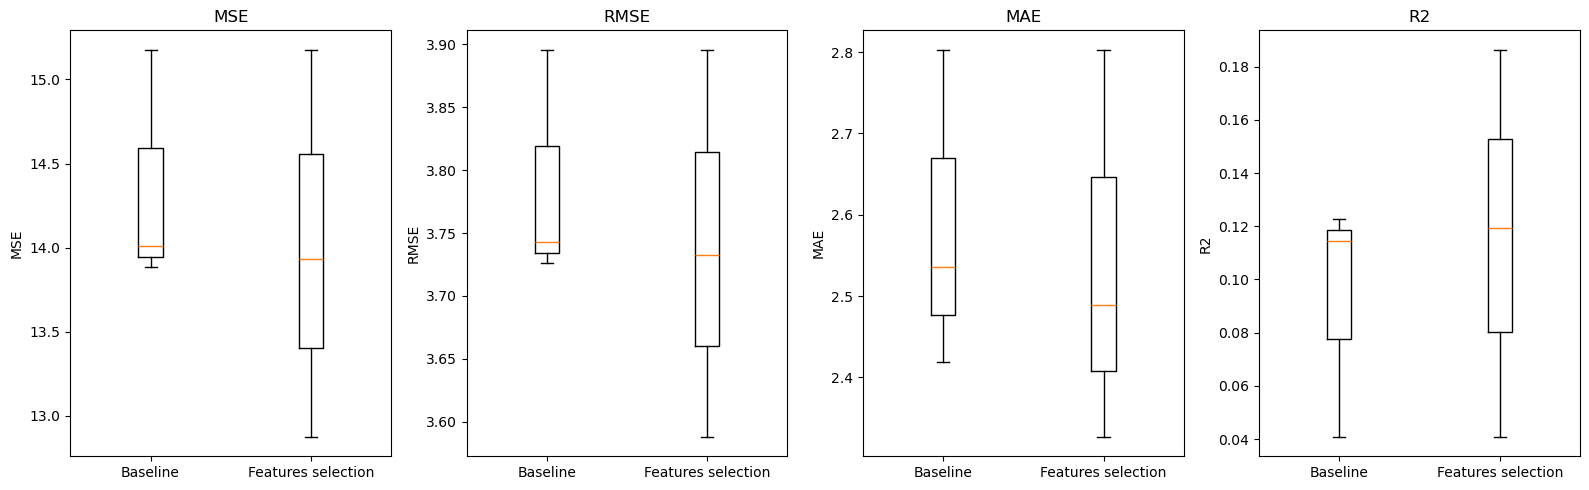

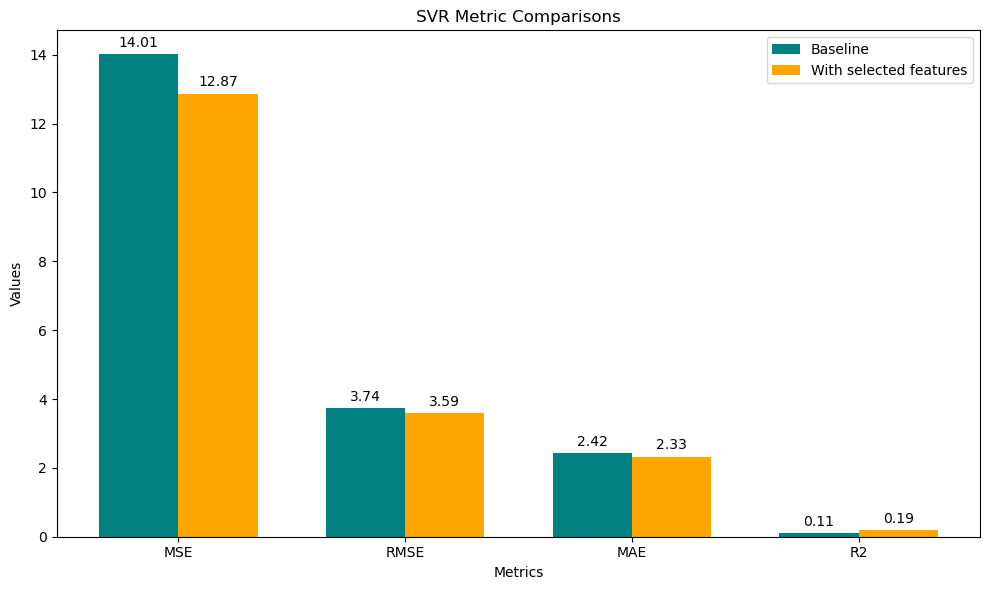

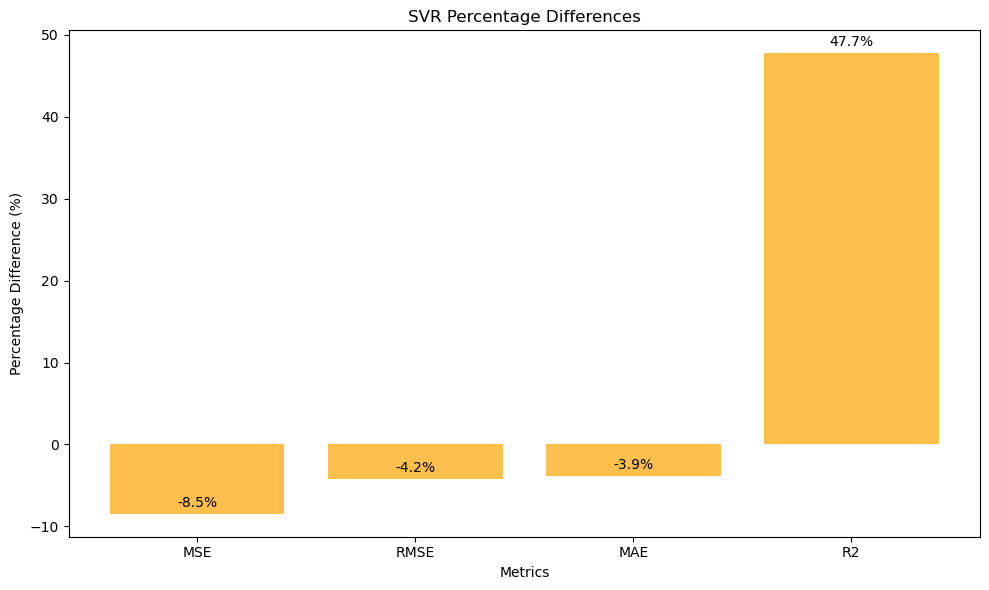

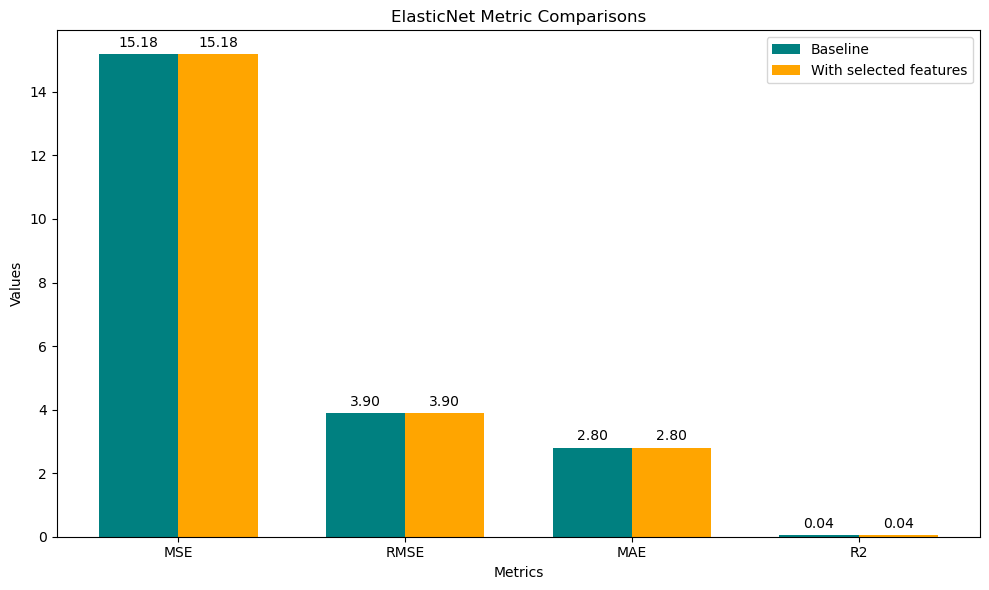

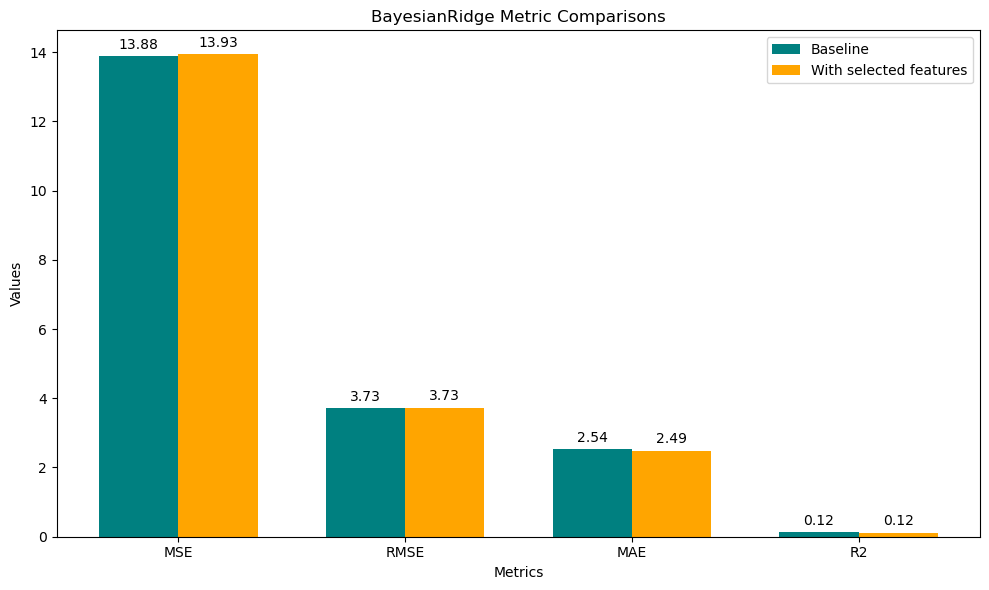

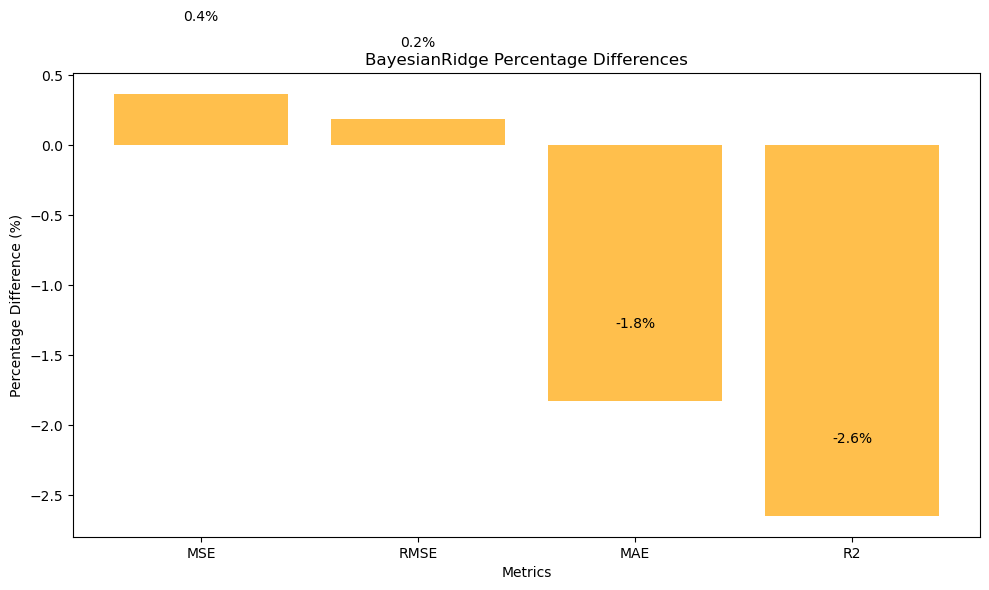

In [4]:
# # Visualization
# def plot_metrics(results_dict, title):
#     df = pd.DataFrame(results_dict).T
#     sns.boxplot(data=df[['RMSE', 'MAE']])
#     plt.title(title)
#     plt.xticks(rotation=45)
#     plt.show()

# plot_metrics(baseline, 'Baseline Models')
# plot_metrics(featsel, 'Feature-Selected Models')
# # plot_metrics(tuned_models, 'Tuned Models')

def plot_metrics2(b, f):
    dfb = pd.DataFrame(b).T
    dff = pd.DataFrame(f).T
    metrics = ["MSE", "RMSE", "MAE", "R2"]
    data = {metric: [dfb[metric].values, dff[metric].values] for metric in metrics}
    fig, axes = plt.subplots(1, len(metrics), figsize=(16, 5), sharey=False)
    for i, metric in enumerate(metrics):
        axes[i].boxplot(data[metric], tick_labels=["Baseline", "Features selection"])
        axes[i].set_title(metric)
        axes[i].set_ylabel(metric)
    plt.tight_layout()
    plt.show()

plot_metrics2(baseline, featsel)

plotModelDiff(baseline, featsel, "With selected features")

Now we have to fine tune our hypermarameters and evaluate the final models.

{
    "ElasticNet": {
        "MSE": 11.598758319456033,
        "RMSE": 3.4056949833266095,
        "MAE": 2.038755626451977,
        "R2": 0.34353907130432215
    },
    "SVR": {
        "MSE": 9.86951730576311,
        "RMSE": 3.1415787919075195,
        "MAE": 1.2137226270527575,
        "R2": 0.44140982009674556
    },
    "BayesianRidge": {
        "MSE": 11.691314726003865,
        "RMSE": 3.4192564580627565,
        "MAE": 2.0365146445662323,
        "R2": 0.33830060845117305
    }
}

## SVR Comparison
Metric     Version 1    Version 2    Absolute Δ   % Δ     
--------------------------------------------------------
MSE        14.0102      9.8695       -4.1407      -34.7   
RMSE       3.7430       3.1416       -0.6014      -17.5   
MAE        2.4186       1.2137       -1.2049      -66.3   
R2         0.1146       0.4414       0.3268       117.6   

## ElasticNet Comparison
Metric     Version 1    Version 2    Absolute Δ   % Δ     
-----------------------------------------------

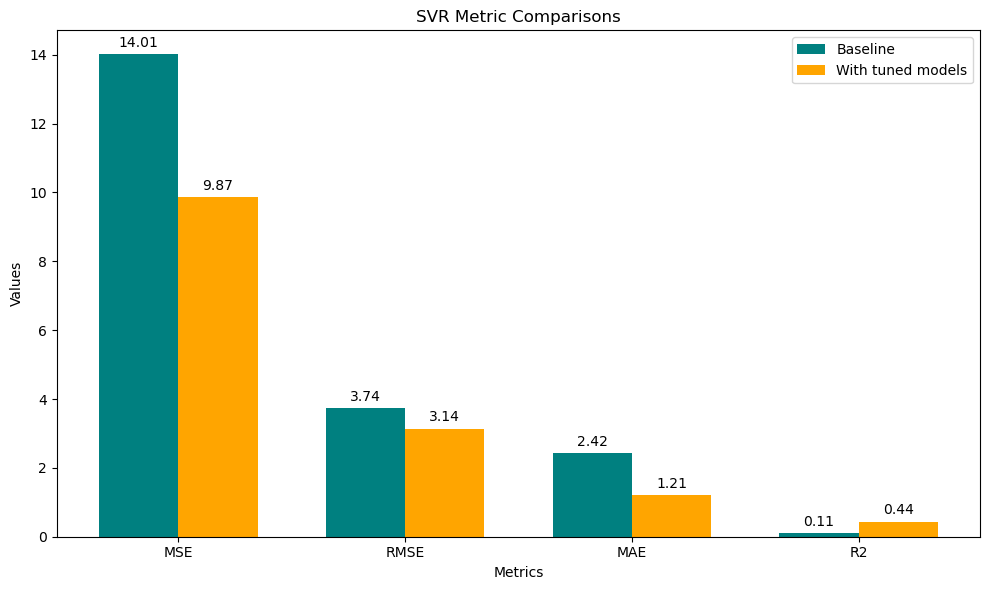

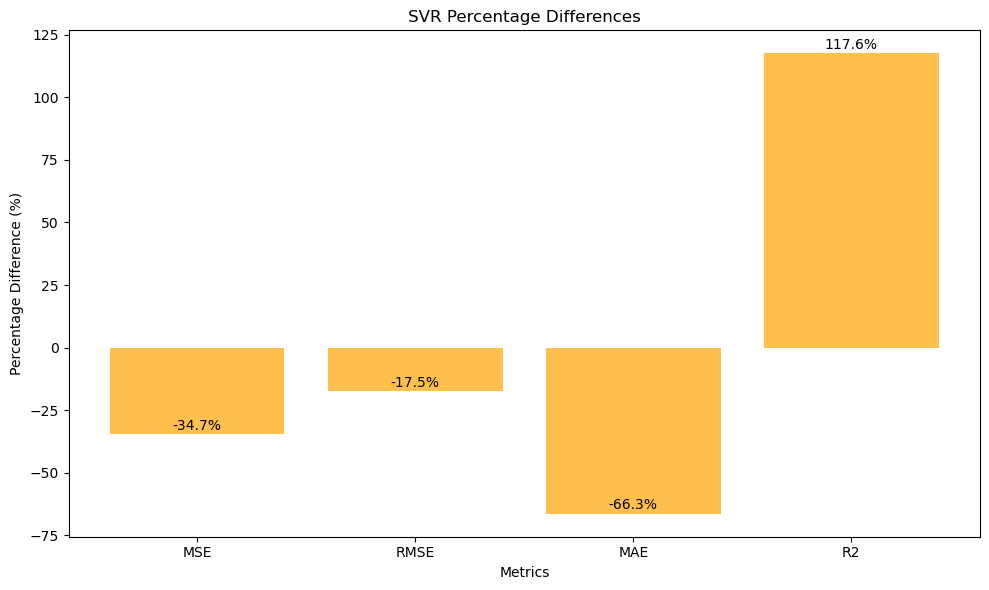

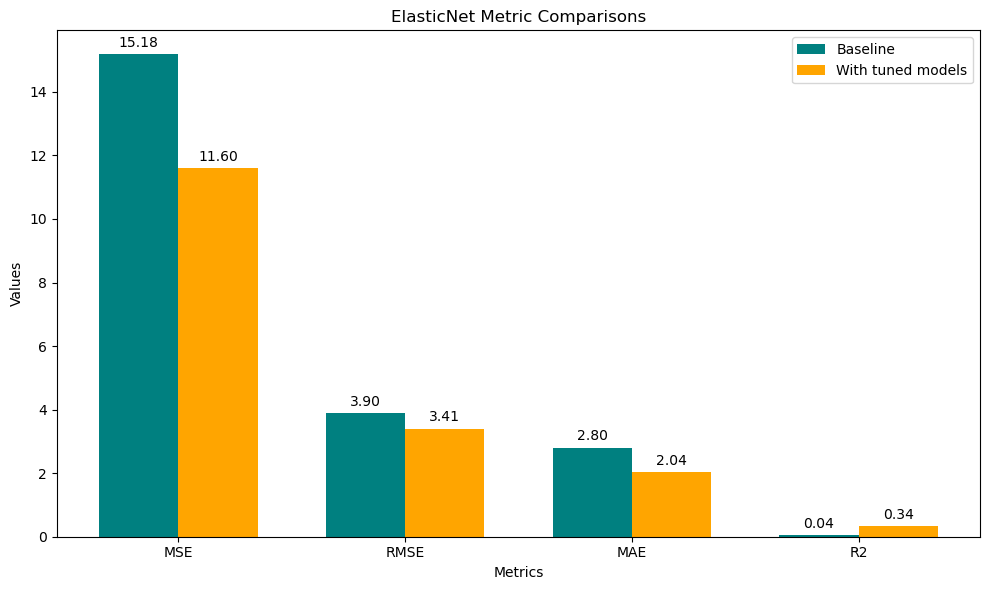

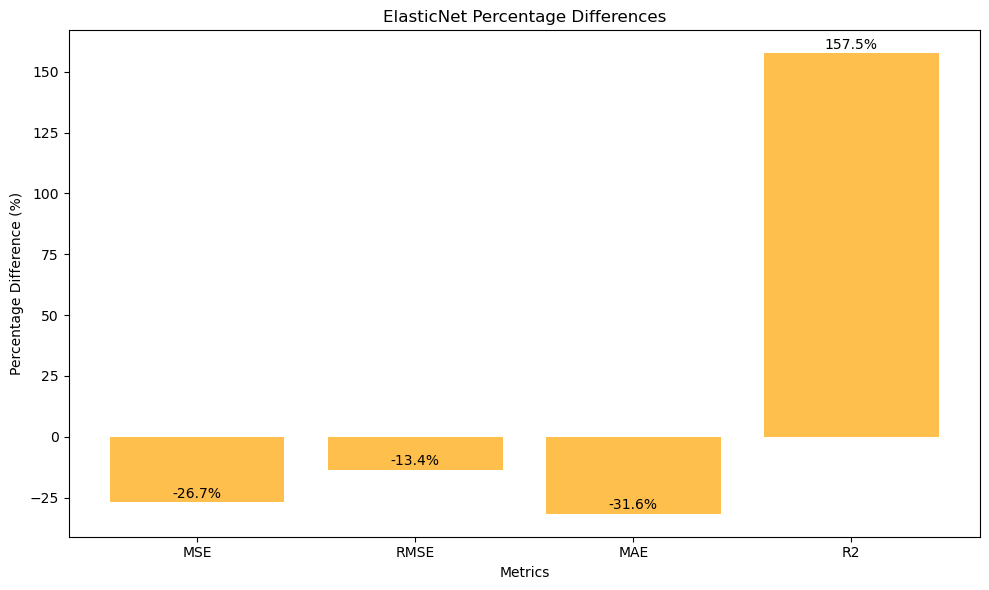

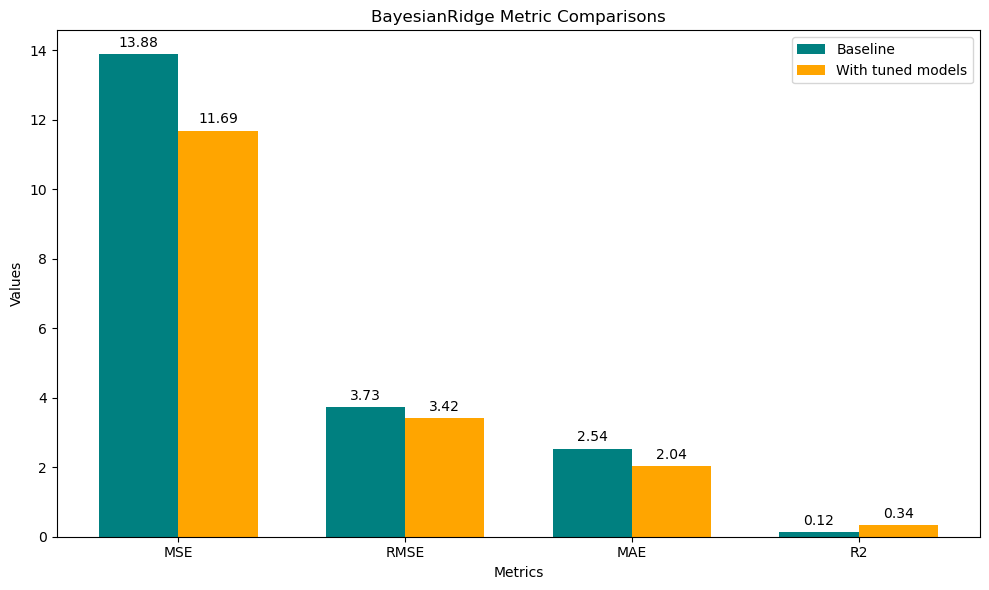

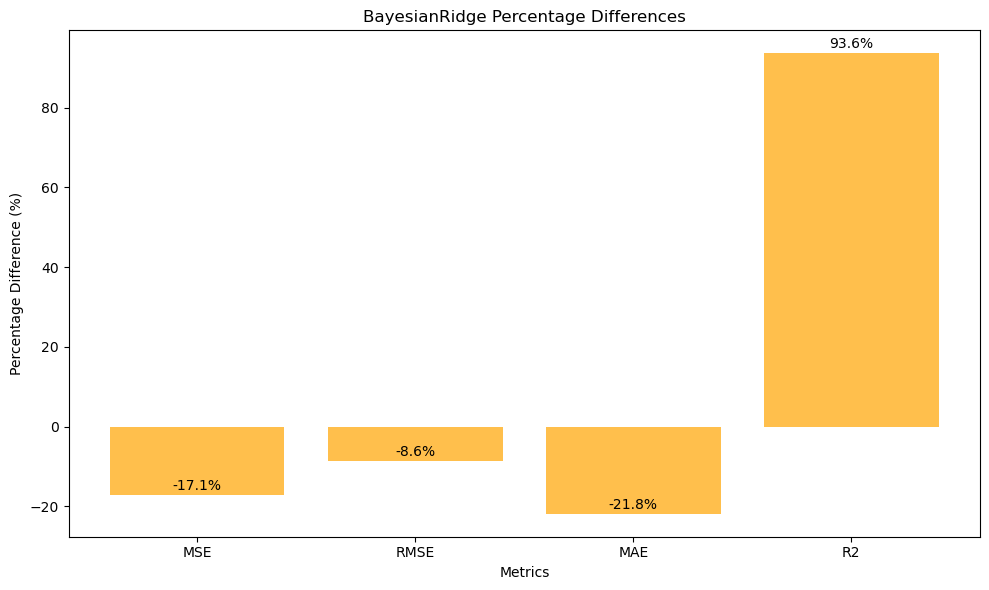

In [5]:
tuned = {}
for modelType in modelsList:
    model = tuneModel(dev, feats, modelType)
    tuned[modelType] = evalModel(model, getFeats(dev)[feats], getTarget(dev))
    # tuned[modelType] = evalModel(model, getFeats(dev), getTarget(dev))
    joblib.dump(model, f'models/tuned_{modelType}.pkl')

print(jdumps(tuned, indent=4))
printModelDiff(baseline, tuned)
plotModelDiff(baseline, tuned, "With tuned models")

Finally, to be able to provide a generalization of the work we did to possibly separate evaluation tests we need to implement a method that will make the proper steps (pipeline) as we have done here and above and also run it with randomized sets from the ones we have.

{"MSE": {"mean": 11.74622869546011, "median": 11.477763456932248, "confidence_interval": [8.101748802380799, 16.045176122818383]}, "RMSE": {"mean": 3.413454229246619, "median": 3.3878848039931437, "confidence_interval": [2.8461207199876566, 4.005591434546132]}, "MAE": {"mean": 2.050928299333248, "median": 2.0523744255894716, "confidence_interval": [1.8591174212729298, 2.2919347450697174]}, "R\u00b2": {"mean": 0.3115246364973524, "median": 0.3118587523812021, "confidence_interval": [0.17649669482755964, 0.4647595348201033]}}
{"MSE": {"mean": 9.381594994134305, "median": 9.040534807885443, "confidence_interval": [6.024801150455987, 14.598655508753088]}, "RMSE": {"mean": 3.0392528685066225, "median": 3.0067437762380127, "confidence_interval": [2.4545286063981875, 3.8208179159527944]}, "MAE": {"mean": 1.186771876437243, "median": 1.181046723662743, "confidence_interval": [1.0159570686155528, 1.3788748428338742]}, "R\u00b2": {"mean": 0.44897563899255494, "median": 0.44621808254393797, "conf

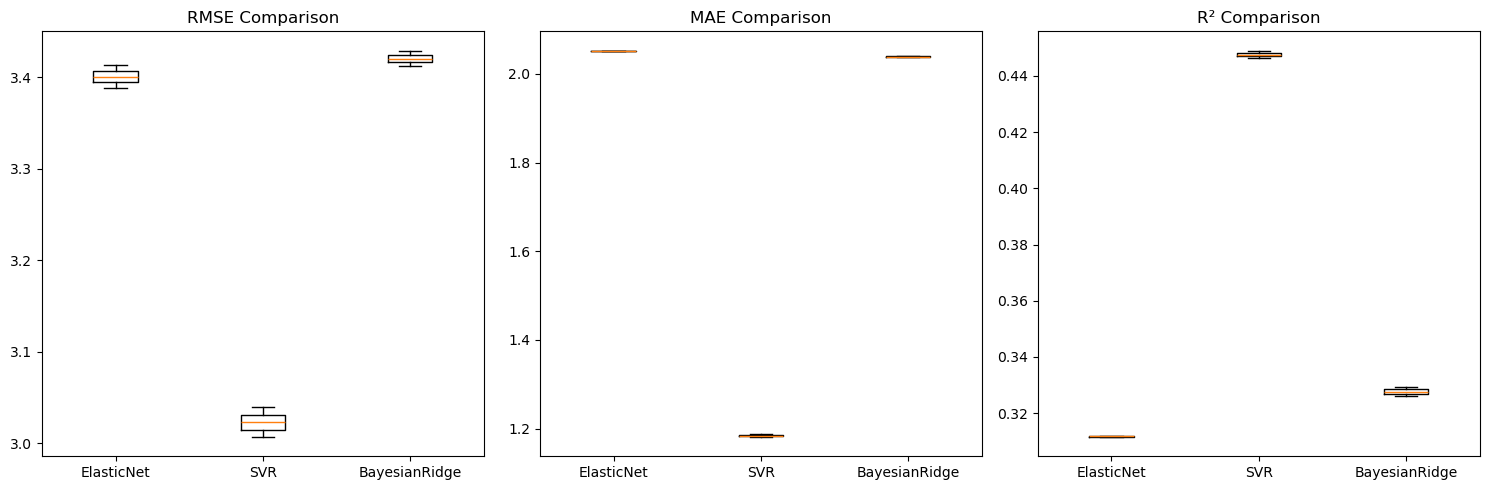

In [6]:
def evalModel(model, dataframe, selFeat, iterations=100):
    # Evaluate a model multiple times using bootstrapped subsets of the evaluation dataset.
    
    # Parameters:
    #   model:        Trained regression model.
    #   dataframe:    The dataframe to be used
    #   n_iterations: Number of bootstrap iterations.
    
    # Returns:
    #     metrics_dict: Dictionary containing mean, median, and confidence intervals for RMSE, MAE, R².

    mse_scores = []
    rmse_scores = []
    mae_scores = []
    r2_scores = []
    
    # t = getFeats(dataframe)[selFeat]
    features = ((getFeats(dataframe))[selFeat])
    target = getTarget(dataframe)

    for _ in range(iterations):
        # Bootstrap sampling
        indices = np.random.choice(len(features), size=len(features), replace=True)
        X_bootstrap = features.iloc[indices]
        y_bootstrap = target[indices]
        
        # Predictions
        predictions = model.predict(X_bootstrap)
        
        # Calculate metrics
        mse_scores.append(mean_squared_error(y_bootstrap, predictions))
        rmse_scores.append(np.sqrt(mean_squared_error(y_bootstrap, predictions)))
        mae_scores.append(mean_absolute_error(y_bootstrap, predictions))
        r2_scores.append(r2_score(y_bootstrap, predictions))
    
    # Calculate statistics
    metrics_dict = {
        'MSE': {
            'mean': np.mean(mse_scores),
            'median': np.median(mse_scores),
            'confidence_interval': (np.percentile(mse_scores, 2.5), np.percentile(mse_scores, 97.5))
        },
        'RMSE': {
            'mean': np.mean(rmse_scores),
            'median': np.median(rmse_scores),
            'confidence_interval': (np.percentile(rmse_scores, 2.5), np.percentile(rmse_scores, 97.5))
        },
        'MAE': {
            'mean': np.mean(mae_scores),
            'median': np.median(mae_scores),
            'confidence_interval': (np.percentile(mae_scores, 2.5), np.percentile(mae_scores, 97.5))
        },
        'R²': {
            'mean': np.mean(r2_scores),
            'median': np.median(r2_scores),
            'confidence_interval': (np.percentile(r2_scores, 2.5), np.percentile(r2_scores, 97.5))
        }
    }
    
    return metrics_dict

results = {}
from json import dump as jdump
from json import load as jload
for modelType in modelsList:
    model = joblib.load(f'models/tuned_{modelType}.pkl')
    results[modelType] = evalModel(model, dev, feats)
    print(jdumps(results[modelType]))
with open("models/evalMetric.json", "w") as f:
    jdump(results, f)

def plot_boxplots(modelMetric):
    # Extract models list
    modelsList = list(modelMetric.keys())
    
    # Flatten RMSE, MAE, and R² data
    rmse_data = [
        [value for key, value in modelMetric[m]['RMSE'].items() if isinstance(value, (int, float))]
        for m in modelsList
    ]
    mae_data = [
        [value for key, value in modelMetric[m]['MAE'].items() if isinstance(value, (int, float))]
        for m in modelsList
    ]
    r2_data = [
        [value for key, value in modelMetric[m]['R²'].items() if isinstance(value, (int, float))]
        for m in modelsList
    ]
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # RMSE boxplot
    axes[0].boxplot(rmse_data, tick_labels=modelsList)
    axes[0].set_title('RMSE Comparison')
    
    # MAE boxplot
    axes[1].boxplot(mae_data, tick_labels=modelsList)
    axes[1].set_title('MAE Comparison')
    
    # R² boxplot
    axes[2].boxplot(r2_data, tick_labels=modelsList)
    axes[2].set_title('R² Comparison')
    
    plt.tight_layout()
    plt.show()

plot_boxplots(results)
